In [1]:
import porespy as ps
import matplotlib.pyplot as plt

import numpy as np
from skimage.transform import radon, iradon
from scipy import ndimage

from pathlib import Path
import cv2

from tqdm import tqdm

In [2]:
def crop(img, shape, center=None):
    def left_edge(index):
        return np.ceil(center[index] - halves[index]).astype(int)

    def right_edge(index):
        return np.ceil(center[index] + halves[index] + odds[index]).astype(int)

    if center is None:
        center = [x // 2 for x in img.shape]

    halves = [x // 2 for x in shape]
    odds = [x % 2 for x in shape]

    ranges = (
        slice(
            left_edge(i),
            right_edge(i)
        )
        for i in range(img.ndim)
    )

    return img[tuple(ranges)]


def create_sinogram(num_of_angles, img):
    set_of_angles = np.linspace(0, 180, num_of_angles, endpoint=False)
    if len(img.shape) == 3:
        sim = np.asarray([radon(img_slice, theta=set_of_angles, circle=False) for img_slice in img])
    else:
        sim = radon(img, theta=set_of_angles, circle=False)

    return sim


def reconstruct(sinogram):
    if len(sinogram.shape) == 3:
        set_of_angles = np.linspace(0, 180, sinogram[0].shape[1], endpoint=False)
        image = [iradon(s, set_of_angles) for s in sinogram]
    else:
        set_of_angles = np.linspace(0, 180, sinogram.shape[1], endpoint=False)
        image = iradon(sinogram, set_of_angles)

    image = np.asarray(image)

    return image


def add_poisson_noise(sinogram, intensity):
    sinogram = sinogram / 100.0  # TODO: add comment why it is so?
    I_0 = np.random.poisson(lam=intensity,
                            size=sinogram.shape
                            ).astype('float32')
    sinogram = np.exp(-sinogram) * I_0

    exposition = 10.0  # TODO: fix magic parameter

    I_0_arr = np.random.poisson(lam=intensity * exposition,
                                size=sinogram.shape).astype('float32') / exposition

    sinogram = np.log(I_0_arr / sinogram)
    sinogram *= 100.0
    sinogram = np.ceil(sinogram)

    return sinogram


def add_poisson_noise_physical(sinogram,
                               nominal_intensity,
                               pixel_size=0.02,
                               frame_count=1,
                               gauss_sigma=0.56):

    I0_empty = np.zeros(sinogram.shape)
    for i in range(frame_count):
        I0_empty += np.round(np.random.poisson(
                                      lam=nominal_intensity,
                                      size=sinogram.shape
                                     ))
    I0_empty /= frame_count 

    I0 = np.random.poisson(lam=nominal_intensity,
                           size=sinogram.shape
                          ).astype('float32')

    experimental_sinogram = I0*np.exp(- sinogram * pixel_size)
    experimental_sinogram = sinogram_detector_blurring(experimental_sinogram, gauss_sigma).astype(int)

    #TODO: here we get rid of zero values. Make it more flexible
    experimental_sinogram[experimental_sinogram < 1] = 1

    noised_radon_sinogram = np.log(I0_empty/experimental_sinogram) / pixel_size
    
    return noised_radon_sinogram, experimental_sinogram


def sinogram_detector_blurring(sinograms, gauss_sigma):
    if not gauss_sigma:
        return sinograms

    _sinograms = np.copy(sinograms).astype(float)
    dim = len(_sinograms.shape)
    num_of_angles = _sinograms.shape[2] if dim == 3 else _sinograms.shape[1]
    result = np.empty_like(_sinograms)
    for angle in np.arange(num_of_angles):
        projection = _sinograms[:, :, angle] if dim == 3 else _sinograms[:, angle]
        projection_dim = len(projection.shape)
        for axis in np.arange(projection_dim):
            output = ndimage.gaussian_filter1d(projection, gauss_sigma, axis)
            projection = output
        result[:, angle] = projection
    return result


def from_absorption_to_phase_contrat(img, k, mu, axis = 0):
    def _apply_filter_function(arr, k = k, mu = mu, axis = axis):
        freq = np.fft.fftfreq(arr.shape[axis])
        filter_func = 1 / (k * freq**2 + mu)
        if axis == 0:
            return np.transpose([row * filter_func for row in arr.T])
        else:
            return np.transpose([row * filter_func for row in arr])

    data_fft = np.fft.fftshift(np.fft.fft(img, axis=0))
    data_fft_cor = _apply_filter_function(data_fft)
    return np.abs(np.fft.ifft(np.fft.ifftshift(data_fft_cor), axis=0))


def process_image(image,
                  angles_number,
                  noise_parameter,
                  noise_method,
                  k=30,
                  mu = 0.1,
                  pixel_size=0.01,
                  frame_count=1,
                  gauss_sigma=0.56):
    """
    :param image:
    :param angles_number:
    :param noise_parameter:
    :param noise_method: should be 'poisson' or None:
    :k: параметр паганинской фильтрации (k*freq + mu)
    :mu: параметр паганинской фильтрации (k*freq + mu)
    :pixel_size:
    :frame_count:
    :gauss_sigma:
    :return:
    """
    image = from_absorption_to_phase_contrat(image.copy(), k = k, mu = mu, axis=0)
    sim0 = create_sinogram(angles_number, image)
    # print("sinogram shape: ", sim0.shape, "min|max", sim0.min(), sim0.max())
    if noise_method == 'poisson':
        sim, _ = add_poisson_noise_physical(sim0,
                                            noise_parameter,
                                            pixel_size,
                                            frame_count,
                                            gauss_sigma)
    elif noise_method is None:
        pass
    else:
        raise ValueError("noise_method should be 'poisson' or None. Given {}".format(noise_method))
    rec = reconstruct(sim)
    # print("reconstruction shape: ", rec.shape)
    return crop(rec, image.shape)


normalize = lambda x: ((x - x.min()) / (x.max() - x.min()) * 255).astype(int)

# Main

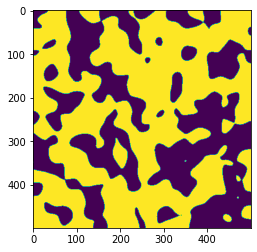

In [3]:
img = ps.generators.blobs(shape=[500, 500], porosity=0.6, blobiness=1)
plt.imshow(img)

In [4]:
img_paths = Path("data_phantoms/imgs/")
mask_paths = Path("data_phantoms/masks/")
img_paths.mkdir(parents=True, exist_ok=True)
mask_paths.mkdir(parents=True, exist_ok=True)

In [6]:
porosity, blobiness = 0.5, 1
k, mu = 30, 0.1
shape = [500, 500]
count = 100


for i in tqdm(range(count)):

    bin_img = ps.generators.blobs(shape=shape, porosity=porosity, blobiness=blobiness)
    proc = process_image(bin_img,
                        180,
                        1000,
                        'poisson',
                        k = k,
                        mu = mu,
                        pixel_size=0.01,
                        frame_count=1,
                        gauss_sigma=0.56)

    cv2.imwrite(str(img_paths.joinpath(f"{i}.tif")), normalize(proc.astype(float)))
    cv2.imwrite(str(mask_paths.joinpath(f"{i}.tif")), normalize(bin_img.astype(float)))


 58%|█████▊    | 58/100 [02:03<01:29,  2.13s/it]